## Xgboost classification on flight delay dataset

In [1]:
from load_data import load_preprocessed_data

X, y = load_preprocessed_data()

print(X[:5])

   month  day_of_month  day_of_week op_unique_carrier origin origin_city_name  \
0      1             1            1                9E    JFK     New York, NY   
1      1             1            1                9E    MSP  Minneapolis, MN   
2      1             1            1                9E    JFK     New York, NY   
3      1             1            1                9E    RIC     Richmond, VA   
4      1             1            1                9E    DTW      Detroit, MI   

  origin_state_nm dest dest_city_name dest_state_nm  dep_time  distance  
0        New York  DTW    Detroit, MI      Michigan  12:47:00     509.0  
1       Minnesota  CLE  Cleveland, OH          Ohio  10:01:00     622.0  
2        New York  RIC   Richmond, VA      Virginia  14:11:00     288.0  
3        Virginia  JFK   New York, NY      New York  16:43:00     288.0  
4        Michigan  MKE  Milwaukee, WI     Wisconsin  10:10:00     237.0  


In [2]:
print(y[:5])

0    False
1    False
2    False
3    False
4    False
Name: is_arr_delayed, dtype: bool


In [ ]:
import pandas as pd
import numpy as np


def hhmm_to_minutes(time_val):
    if pd.isna(time_val):
        return np.nan

    try:
        if isinstance(time_val, str) and ':' in time_val:
            parts = time_val.split(':')
            hour = int(parts[0])
            minute = int(parts[1])

            if hour == 24:
                return 0

            return hour * 60 + minute
        s = str(int(float(time_val))).zfill(4)
        if s == '2400':
            return 0
        hour = int(s[:2])
        minute = int(s[2:])
        return hour * 60 + minute

    except (ValueError, TypeError, IndexError):
        return np.nan


cols_to_drop = ['origin_city_name', 'origin_state_nm', 'dest_city_name', 'dest_state_nm']
cols_to_drop_existing = [col for col in cols_to_drop if col in X.columns]
if cols_to_drop_existing:
    X = X.drop(columns=cols_to_drop_existing)


if 'dep_time' in X.columns:
    X['dep_time_minutes'] = X['dep_time'].apply(hhmm_to_minutes)

    X['dep_time_sin'] = np.sin(2 * np.pi * X['dep_time_minutes'] / 1440.0)
    X['dep_time_cos'] = np.cos(2 * np.pi * X['dep_time_minutes'] / 1440.0)
    X = X.drop(columns=['dep_time', 'dep_time_minutes'])

if 'month' in X.columns:
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12.0)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12.0)
    X = X.drop(columns=['month'])

if 'day_of_week' in X.columns:
    X['day_of_week_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 7.0)
    X['day_of_week_cos'] = np.cos(2 * np.pi * X['day_of_week'] / 7.0)
    X = X.drop(columns=['day_of_week'])

if 'day_of_month' in X.columns:
    X['day_of_month_sin'] = np.sin(2 * np.pi * X['day_of_month'] / 31.0)
    X['day_of_month_cos'] = np.cos(2 * np.pi * X['day_of_month'] / 31.0)
    X = X.drop(columns=['day_of_month'])


categorical_cols = ['op_unique_carrier', 'origin', 'dest']
for col in categorical_cols:
    if col in X.columns:
        X[col] = X[col].astype('category')


Rozpoczynam selekcję cech...
Usunięto redundantne kolumny: ['origin_city_name', 'origin_state_nm', 'dest_city_name', 'dest_state_nm']
Rozpoczynam kodowanie cykliczne...
Kodowanie 'dep_time'...
Kodowanie 'month'...
Kodowanie 'day_of_week'...
Kodowanie 'day_of_month'...
Kodowanie cykliczne zakończone.
Rozpoczynam kodowanie kategoryczne...
Konwersja 'op_unique_carrier' na typ 'category'...
Konwersja 'origin' na typ 'category'...
Konwersja 'dest' na typ 'category'...
Przygotowanie danych (X) zakończone.


In [4]:
print(X[:5])

  op_unique_carrier origin dest  distance  dep_time_sin  dep_time_cos  \
0                9E    JFK  DTW     509.0     -0.203642     -0.979045   
1                9E    MSP  CLE     622.0      0.496217     -0.868199   
2                9E    JFK  RIC     288.0     -0.540974     -0.841039   
3                9E    RIC  JFK     288.0     -0.944089     -0.329691   
4                9E    DTW  MKE     237.0      0.461749     -0.887011   

   month_sin  month_cos  day_of_week_sin  day_of_week_cos  day_of_month_sin  \
0        0.5   0.866025         0.781831          0.62349          0.201299   
1        0.5   0.866025         0.781831          0.62349          0.201299   
2        0.5   0.866025         0.781831          0.62349          0.201299   
3        0.5   0.866025         0.781831          0.62349          0.201299   
4        0.5   0.866025         0.781831          0.62349          0.201299   

   day_of_month_cos  
0           0.97953  
1           0.97953  
2           0.97953 

In [5]:
X.columns

Index(['op_unique_carrier', 'origin', 'dest', 'distance', 'dep_time_sin',
       'dep_time_cos', 'month_sin', 'month_cos', 'day_of_week_sin',
       'day_of_week_cos', 'day_of_month_sin', 'day_of_month_cos'],
      dtype='object')

**Baseline XGBoost**

/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:41:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:41:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/core.py:2676: UserWarning: [21:41:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

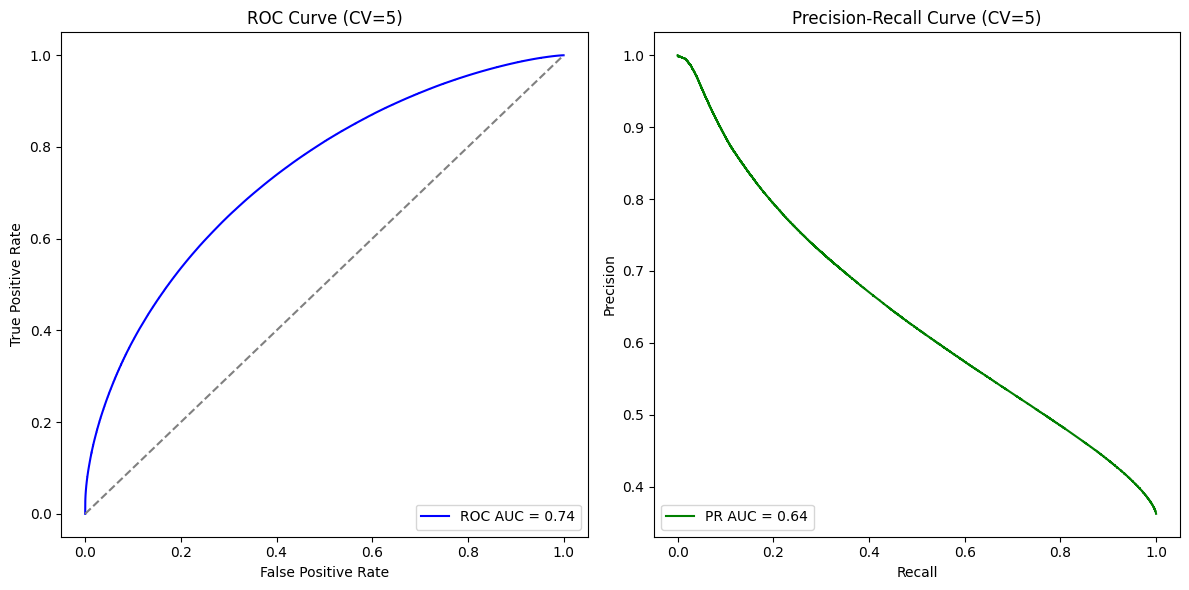

In [8]:
from evaluation import evaluate_model
from xgboost import XGBClassifier


clf = XGBClassifier(tree_method='gpu_hist',
    predictor='gpu_predictor',
    enable_categorical=True,
    random_state=42
    )

metrics = evaluate_model(clf, X, y)



Accuracy: 0.7113146863307158

Classification Report:
              precision    recall  f1-score       support
False          0.720464  0.894528  0.798116  4.443258e+06
True           0.676470  0.388530  0.493575  2.522008e+06
accuracy       0.711315  0.711315  0.711315  7.113147e-01
macro avg      0.698467  0.641529  0.645846  6.965266e+06
weighted avg   0.704534  0.711315  0.687847  6.965266e+06

Confusion Matrix:


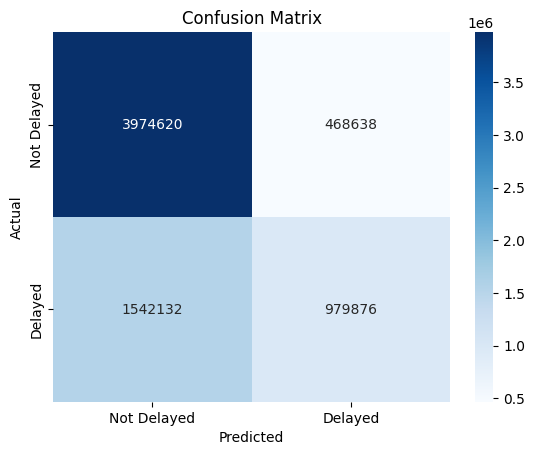

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


print("\nAccuracy:", metrics['accuracy'])
print("\nClassification Report:")
class_report_df = pd.DataFrame(metrics['classification_report']).transpose()
print(class_report_df)

print("\nConfusion Matrix:")
conf_matrix = metrics['confusion_matrix']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Class weight optimized XGBoost**

/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:43:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/core.py:2676: UserWarning: [21:43:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

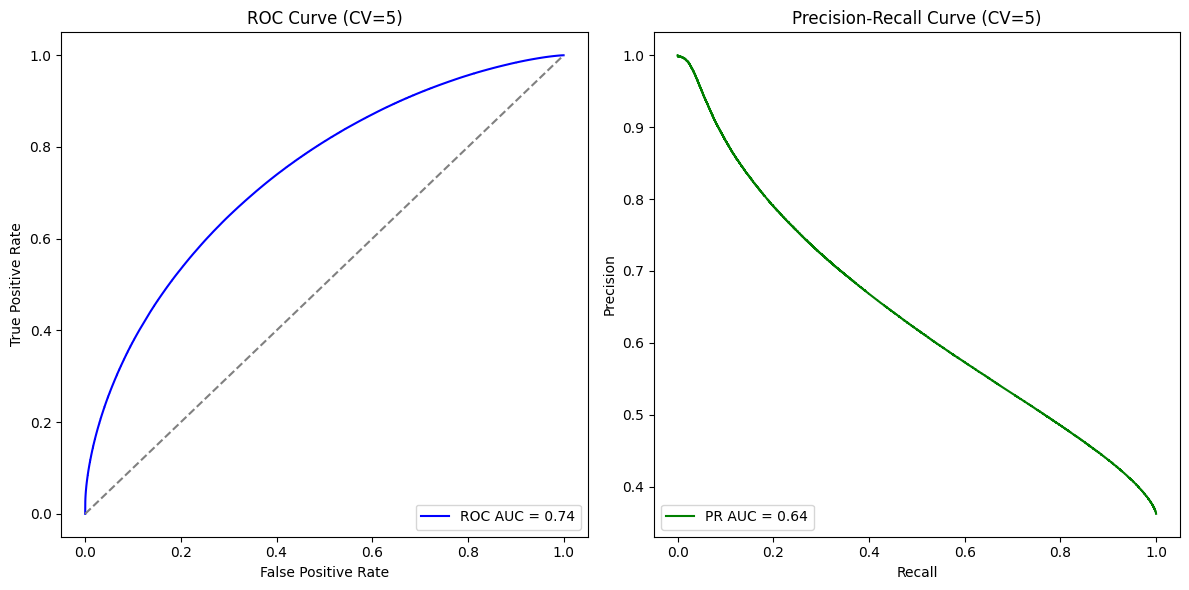

{'accuracy': 0.7057349999267796, 'classification_report': {'False': {'precision': 0.7477803919230365, 'recall': 0.8128895508656035, 'f1-score': 0.7789768358712402, 'support': 4443258.0}, 'True': {'precision': 0.610619286658355, 'recall': 0.5169507789031597, 'f1-score': 0.5598944588762808, 'support': 2522008.0}, 'accuracy': 0.7057349999267796, 'macro avg': {'precision': 0.6791998392906957, 'recall': 0.6649201648843817, 'f1-score': 0.6694356473737605, 'support': 6965266.0}, 'weighted avg': {'precision': 0.6981166167324883, 'recall': 0.7057349999267796, 'f1-score': 0.6996507186145118, 'support': 6965266.0}}, 'confusion_matrix': array([[3611878,  831380],
       [1218254, 1303754]]), 'roc_auc': 0.7415374006204254, 'pr_auc': 0.6396115645665046, 'fpr': array([0.        , 0.        , 0.        , ..., 0.99997884, 0.99997884,
       1.        ], shape=(3200953,)), 'tpr': array([0.00000000e+00, 3.96509448e-07, 1.22917929e-05, ...,
       9.99999603e-01, 1.00000000e+00, 1.00000000e+00], shape=(32

In [10]:
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier


negative_count = len(y) - sum(y)
positive_count = sum(y)
scale_pos_weight = sqrt(negative_count / positive_count)

clf = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    enable_categorical=True,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
metrics = evaluate_model(clf, X, y)
print(metrics)


Accuracy: 0.7057349999267796

Classification Report:
              precision    recall  f1-score       support
False          0.747780  0.812890  0.778977  4.443258e+06
True           0.610619  0.516951  0.559894  2.522008e+06
accuracy       0.705735  0.705735  0.705735  7.057350e-01
macro avg      0.679200  0.664920  0.669436  6.965266e+06
weighted avg   0.698117  0.705735  0.699651  6.965266e+06

Confusion Matrix:


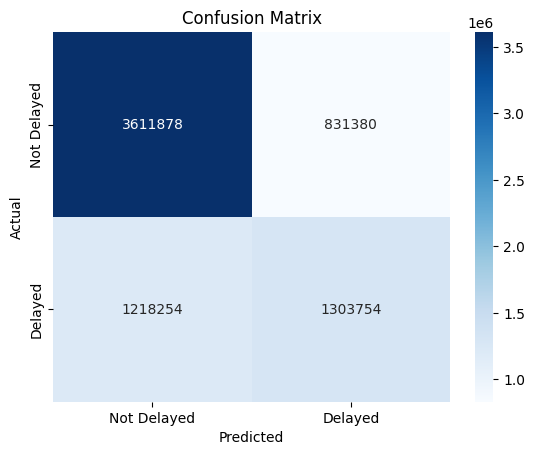

In [11]:
print("\nAccuracy:", metrics['accuracy'])
print("\nClassification Report:")
class_report_df = pd.DataFrame(metrics['classification_report']).transpose()
print(class_report_df)

print("\nConfusion Matrix:")
conf_matrix = metrics['confusion_matrix']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Hyperparams optimized XGBoost**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint
import warnings

warnings.filterwarnings('ignore')


clf_xgb = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    enable_categorical=True,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)


param_dist = {
    'n_estimators': randint(200, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(5, 12),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 4)
}


kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


random_search = RandomizedSearchCV(
    estimator=clf_xgb,
    param_distributions=param_dist,
    n_iter=40,
    scoring='average_precision',
    cv=kfold,
    verbose=2,
    random_state=42,
    n_jobs=1
)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

random_search.fit(X_train, y_train)

print(f"Najlepsze parametry: {random_search.best_params_}")
print(f"Najlepszy wynik (Average Precision): {random_search.best_score_}")


best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
classification_report(y_test, y_pred)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.15639878836228102, max_depth=9, n_estimators=220, reg_alpha=0.15601864044243652, reg_lambda=1.6239780813448106, subsample=0.7174250836504598; total time=  12.1s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.15639878836228102, max_depth=9, n_estimators=220, reg_alpha=0.15601864044243652, reg_lambda=1.6239780813448106, subsample=0.7174250836504598; total time=  10.4s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.15639878836228102, max_depth=9, n_estimators=220, reg_alpha=0.15601864044243652, reg_lambda=1.6239780813448106, subsample=0.7174250836504598; total time=  12.9s
[CV] END colsample_bytree=0.9598528437324805, gamma=0.3005575058716044, learning_rate=0.1516145155592091, max_depth=10, n_estimators=508, reg_alpha=0.9699098521619943, reg_lambda=4.3297705632

'              precision    recall  f1-score   support\n\n       False       0.80      0.85      0.82    889236\n        True       0.70      0.63      0.66    503818\n\n    accuracy                           0.77   1393054\n   macro avg       0.75      0.74      0.74   1393054\nweighted avg       0.76      0.77      0.77   1393054\n'

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.85      0.82    889236
        True       0.70      0.63      0.66    503818

    accuracy                           0.77   1393054
   macro avg       0.75      0.74      0.74   1393054
weighted avg       0.76      0.77      0.77   1393054



In [ ]:
print(random_search.best_params_)

{'colsample_bytree': np.float64(0.7211248392548631), 'gamma': np.float64(0.10445935880768009), 'learning_rate': np.float64(0.14422870336481014), 'max_depth': 11, 'n_estimators': 838, 'reg_alpha': np.float64(0.5183296523637367), 'reg_lambda': np.float64(4.509492287711822), 'subsample': np.float64(0.9222305853262613)}


{'colsample_bytree': np.float64(0.7211248392548631), 'gamma': np.float64(0.10445935880768009), 'learning_rate': np.float64(0.14422870336481014), 'max_depth': 11, 'n_estimators': 838, 'reg_alpha': np.float64(0.5183296523637367), 'reg_lambda': np.float64(4.509492287711822), 'subsample': np.float64(0.9222305853262613)}

In [7]:
best_params = {'colsample_bytree': np.float64(0.7211248392548631), 'gamma': np.float64(0.10445935880768009), 'learning_rate': np.float64(0.14422870336481014), 'max_depth': 11, 'n_estimators': 838, 'reg_alpha': np.float64(0.5183296523637367), 'reg_lambda': np.float64(4.509492287711822), 'subsample': np.float64(0.9222305853262613)}

/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:51:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:51:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Current catalog (cwd): /home/adam/university/sem5/machine_learning/Project/src/classification
Project root directory: /home/adam/university/sem5/machine_learning/Project


/home/adam/anaconda3/envs/flight-delay/lib/python3.13/pickle.py:576: UserWarning: [21:52:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  rv = reduce(self.proto)


Model saved in: /home/adam/university/sem5/machine_learning/Project/models/classification/best_xgb.joblib


/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:52:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:52:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/core.py:2676: UserWarning: [21:53:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

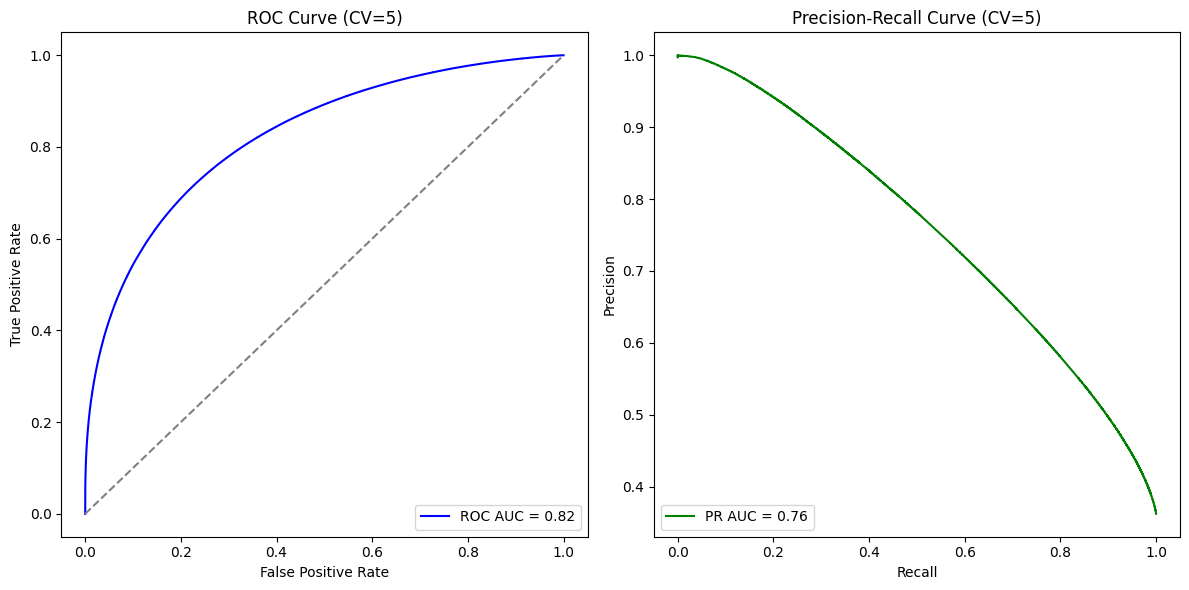

In [9]:
from xgboost import XGBClassifier
from math import sqrt
from evaluation import evaluate_model
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split


negative_count = len(y) - sum(y)
positive_count = sum(y)
scale_pos_weight = sqrt(negative_count / positive_count)

clf_xgb = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    enable_categorical=True,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    **best_params
)

best_model = clf_xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

best_model.fit(X_train, y_train)

try:
    current_dir = Path.cwd()
    print(f"Current catalog (cwd): {current_dir}")
except NameError:
    current_dir = Path(".")

project_root = current_dir.parent.parent

print(f"Project root directory: {project_root}")

target_dir = project_root / "models" / "classification"

target_dir.mkdir(parents=True, exist_ok=True)

model_filename = "best_xgb.joblib"
save_path = target_dir / model_filename

joblib.dump(best_model, save_path)

print(f"Model saved in: {save_path}")

metrics = evaluate_model(clf_xgb, X, y)


Accuracy: 0.7682460368347741

Classification Report:
              precision    recall  f1-score       support
False          0.801142  0.846923  0.823397  4.443258e+06
True           0.700119  0.629634  0.663008  2.522008e+06
accuracy       0.768246  0.768246  0.768246  7.682460e-01
macro avg      0.750631  0.738278  0.743202  6.965266e+06
weighted avg   0.764563  0.768246  0.765323  6.965266e+06

Confusion Matrix:


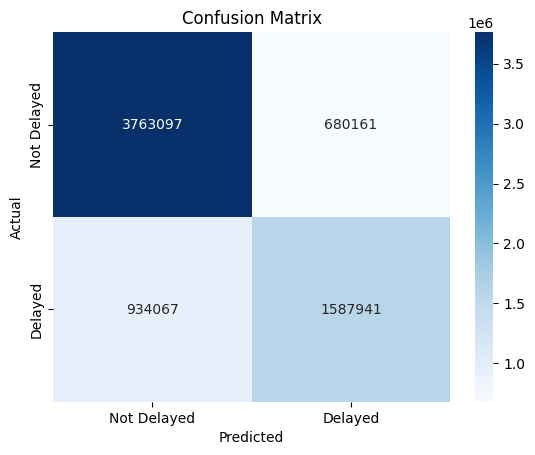

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

print("\nAccuracy:", metrics['accuracy'])
print("\nClassification Report:")
class_report_df = pd.DataFrame(metrics['classification_report']).transpose()
print(class_report_df)

print("\nConfusion Matrix:")
conf_matrix = metrics['confusion_matrix']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np
import joblib


best_model = joblib.load("../../models/classification/best_xgb.joblib")

y_probs = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

precision = precision[:-1]
recall = recall[:-1]

/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/xgboost/core.py:2676: UserWarning: [22:03:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


In [ ]:
f1_scores = 2 * (precision * recall) / (precision + recall)

best_ix = np.argmax(f1_scores)

best_threshold_f1 = thresholds[best_ix]
best_f1 = f1_scores[best_ix]
best_precision_f1 = precision[best_ix]
best_recall_f1 = recall[best_ix]

print(f"--- Best threshold (F1-Score) ---")
print(f"Best threshold: {best_threshold_f1:.4f}")
print(f"Its F1-Score: {best_f1:.4f}")
print(f"Precision: {best_precision_f1:.4f}")
print(f"Recall: {best_recall_f1:.4f}")

--- Najlepszy próg (wg F1-Score) ---
Najlepszy próg: 0.4125
Osiągnięty F1-Score: 0.6769
Precision przy tym progu: 0.6266
Recall przy tym progu: 0.7360


In [ ]:
import numpy as np
from sklearn.metrics import classification_report


FINAL_THRESHOLD = 0.4125

y_probs_final = best_model.predict_proba(X_test)[:, 1]

y_pred_final = (y_probs_final >= FINAL_THRESHOLD).astype(int)

print("\n--- FINAL REPORT (threshold 0.4125) ---")
print(classification_report(y_test, y_pred_final))


--- FINALNY RAPORT (z progiem 0.4125) ---
              precision    recall  f1-score   support

       False       0.83      0.75      0.79    889236
        True       0.63      0.74      0.68    503818

    accuracy                           0.75   1393054
   macro avg       0.73      0.74      0.73   1393054
weighted avg       0.76      0.75      0.75   1393054



In [ ]:
import json
from pathlib import Path


current_dir = Path.cwd()
project_root = current_dir.parent.parent
target_dir = project_root / "models" / "classification"

config_data = {
    "decision_threshold": FINAL_THRESHOLD
}

with open(target_dir / 'xgb_model_config.json', 'w') as f:
    json.dump(config_data, f)

print(f"Threshold {FINAL_THRESHOLD} saved in 'xgb_model_config.json'")

Próg 0.4125 zapisany w 'xgb_model_config.json'
